In [1]:
import cv2
import tensorflow as tf
tf.compat.v1.disable_eager_execution()
from tensorflow.keras.layers import Conv2D, Dense, Flatten, Input, MaxPool2D, Conv2DTranspose, UpSampling2D, Reshape, Lambda, LeakyReLU
from tensorflow.keras.models import Sequential, Model
import tensorflow.keras.backend as K
import numpy as np
import matplotlib.pyplot as plt
import time

In [2]:
# results_AU movie is made with many frames
# Let's continue by skipping frames to have more diverse positions of the monster

In [3]:
output_path = 'video.avi'
fps = 10
image_counter=39835+1
memory_size = 3200
batch_size = 32
losses = []
frames = []

In [4]:
# reparameterization trick
# instead of sampling from Q(z|X), sample eps = N(0,I)
# then z = z_mean + sqrt(var)*eps
def sampling(args):
    """Reparameterization trick by sampling fr an isotropic unit Gaussian.

    # Arguments
        args (tensor): mean and log of variance of Q(z|X)

    # Returns
        z (tensor): sampled latent vector
    """

    z_mean, z_log_var = args
    batch = K.shape(z_mean)[0]
    dim = K.int_shape(z_mean)[1]
    # by default, random_normal has mean=0 and std=1.0
    epsilon = K.random_normal(shape=(batch, dim))
    return z_mean + K.exp(0.5 * z_log_var) * epsilon


In [5]:
480 * 640 * 3

921600

In [6]:
# out = vae_loss_test(images, autoencoder_model.predict(images))

In [7]:
# sess = tf.compat.v1.Session()

# # Evaluate the tensor `c`.
# print(sess.run(out[0]))
# print(sess.run(K.mean(out[1])))

In [8]:
from tensorflow.keras import metrics
# at 36892: relaxing kl loss 9000 -> 90000
def vae_loss(y_true, y_pred):
    # The size of the image is (480, 640, 3) so that is why we do the (480, 640, 3)
    xent_loss = metrics.mse(K.flatten(y_true), K.flatten(y_pred))
    kl_loss = - 0.5 * K.sum(1 + z_log_var - K.square(z_mean) - K.exp(z_log_var), axis=-1)
    vae_loss = K.mean(xent_loss + kl_loss/90000)
    return vae_loss

def my_vae_loss(y_true, y_pred):
    # The size of the image is (480, 640, 3) so that is why we do the (480, 640, 3)
    xent_loss = metrics.mse(K.flatten(y_true), K.flatten(y_pred))
    kl_loss = - 0.5 * K.sum(1 + z_log_var - K.square(z_mean) - K.exp(z_log_var), axis=-1)
    vae_loss = K.mean(xent_loss + kl_loss/9000)
    return vae_loss

In [9]:
plt.imshow(frames[0])

IndexError: list index out of range

In [10]:
encoder_input_layer = Input([480, 640,3])

encoder_layers = Conv2D(8, (3,3), activation="relu", padding="same")(encoder_input_layer)
encoder_layers = MaxPool2D()(encoder_layers)

encoder_layers = Conv2D(16, (3,3), activation="relu", padding="same")(encoder_layers)
encoder_layers = MaxPool2D()(encoder_layers)

encoder_layers = Conv2D(32, (3,3), activation="relu", padding="same")(encoder_layers)
encoder_layers = MaxPool2D()(encoder_layers)

encoder_layers = Conv2D(32, (3,3), activation="relu", padding="same")(encoder_layers)
encoder_layers = MaxPool2D()(encoder_layers)

encoder_layers = Flatten()(encoder_layers)

encoder_layers = Dense(32)(encoder_layers)


# Create the Variational encoder part
z_mean = Dense(16, name='z_mean')(encoder_layers)
z_log_var = Dense(16, name='z_log_var')(encoder_layers)
encoder_layers = Lambda(sampling, output_shape=(16,), name='z')([z_mean, z_log_var])

# variational_encoder_kl_part = Model(input_layer, [z_mean, z_log_var, z])


# decoder_input_layer = Input([32])

decoder_layers = Dense(38400, input_shape=[16])(encoder_layers)

decoder_layers = Reshape([30, 40, 32])(decoder_layers)

decoder_layers = UpSampling2D()(decoder_layers)
decoder_layers = Conv2DTranspose(32, (3,3), activation="relu", padding="same")(decoder_layers)

decoder_layers = UpSampling2D()(decoder_layers)
decoder_layers = Conv2DTranspose(32, (3,3), activation="relu", padding="same")(decoder_layers)

decoder_layers = UpSampling2D()(decoder_layers)
decoder_layers = Conv2DTranspose(16, (3,3), activation="relu", padding="same")(decoder_layers)

decoder_layers = UpSampling2D()(decoder_layers)
decoder_layers = Conv2DTranspose(8, (3,3), activation="relu", padding="same")(decoder_layers)

decoder_layers = Conv2D(3, (3,3), activation="sigmoid", padding="same")(decoder_layers)

# Models 
autoencoder_model = Model(encoder_input_layer, decoder_layers)
encoder_model = Model(encoder_input_layer, encoder_layers)
decoder_model = Sequential(autoencoder_model.layers[14:])

Instructions for updating:
If using Keras pass *_constraint arguments to layers.


In [11]:
# decoder_model = Sequential(autoencoder_model.layers[14:])
# decoder_model.inputs

In [12]:
# autoencoder_model.layers[13:]

In [13]:


# Compile model
autoencoder_model.compile(optimizer="adam", loss=vae_loss)

In [14]:
# plt.imshow(autoencoder_model.predict(np.expand_dims(frame,0))[0])
# plt.figure()
# plt.imshow(frame)

In [15]:
# autoencoder_model.save_weights("./weights/AU_01_04_2020_0.h5")

In [17]:
# autoencoder_model.load_weights("./weights/AU_01_04_2020_0.h5")
# autoencoder_model.load_weights("./weights/vae_temp_{}.h5".format(image_counter-1))
autoencoder_model.load_weights("./pretrained_weights/VAE_good_10_04_2020.h5")

In [18]:

from __future__ import print_function
import vizdoom as vzd

from random import choice
from time import sleep

vizdoom_path = "../../../../Mech Punk/Anaconda3/envs/vizdoom/lib/vizdoom/scenarios/"

if __name__ == "__main__":
    # Create DoomGame instance. It will run the game and communicate with you.
    game = vzd.DoomGame()

    # Now it's time for configuration!
    # load_config could be used to load configuration instead of doing it here with code.
    # If load_config is used in-code configuration will also work - most recent changes will add to previous ones.
    # game.load_config("../../scenarios/basic.cfg")

    # Sets path to additional resources wad file which is basically your scenario wad.
    # If not specified default maps will be used and it's pretty much useless... unless you want to play good old Doom.
    game.set_doom_scenario_path(vizdoom_path + "basic.wad")
    # Sets map to start (scenario .wad files can contain many maps).
    game.set_doom_map("map01")

    # Sets resolution. Default is 320X240
    game.set_screen_resolution(vzd.ScreenResolution.RES_640X480)

    # Sets the screen buffer format. Not used here but now you can change it. Default is CRCGCB.
    game.set_screen_format(vzd.ScreenFormat.RGB24)

    # Enables depth buffer.
    game.set_depth_buffer_enabled(True)

    # Enables labeling of in game objects labeling.
    game.set_labels_buffer_enabled(True)

    # Enables buffer with top down map of the current episode/level.
    game.set_automap_buffer_enabled(True)

    # Enables information about all objects present in the current episode/level.
    game.set_objects_info_enabled(True)

    # Enables information about all sectors (map layout).
    game.set_sectors_info_enabled(True)

    # Sets other rendering options (all of these options except crosshair are enabled (set to True) by default)
    game.set_render_hud(False)
    game.set_render_minimal_hud(False)  # If hud is enabled
    game.set_render_crosshair(False)
    game.set_render_weapon(True)
    game.set_render_decals(False)  # Bullet holes and blood on the walls
    game.set_render_particles(False)
    game.set_render_effects_sprites(False)  # Smoke and blood
    game.set_render_messages(False)  # In-game messages
    game.set_render_corpses(False)
    game.set_render_screen_flashes(True)  # Effect upon taking damage or picking up items

    # Adds buttons that will be allowed.
    game.add_available_button(vzd.Button.MOVE_LEFT)
    game.add_available_button(vzd.Button.MOVE_RIGHT)
    game.add_available_button(vzd.Button.ATTACK)

    # Adds game variables that will be included in state.
    game.add_available_game_variable(vzd.GameVariable.AMMO2)

    # Causes episodes to finish after 200 tics (actions)
    game.set_episode_timeout(200)

    # Makes episodes start after 10 tics (~after raising the weapon)
    game.set_episode_start_time(10)

    # Makes the window appear (turned on by default)
    game.set_window_visible(False)

    # Turns on the sound. (turned off by default)
    game.set_sound_enabled(False)

    # Sets the livin reward (for each move) to -1
    game.set_living_reward(-1)

    # Sets ViZDoom mode (PLAYER, ASYNC_PLAYER, SPECTATOR, ASYNC_SPECTATOR, PLAYER mode is default)
    game.set_mode(vzd.Mode.PLAYER)

    # Enables engine output to console.
    #game.set_console_enabled(True)

    # Initialize the game. Further configuration won't take any effect from now on.
    game.init()

    # Define some actions. Each list entry corresponds to declared buttons:
    # MOVE_LEFT, MOVE_RIGHT, ATTACK
    # game.get_available_buttons_size() can be used to check the number of available buttons.
    # 5 more combinations are naturally possible but only 3 are included for transparency when watching.
    actions = [[True, False, False], [False, True, False], [False, False, True]]

    # Run this many episodes
    episodes = 100000000

    # Sets time that will pause the engine after each action (in seconds)
    # Without this everything would go too fast for you to keep track of what's happening.
    sleep_time = 1.0 / vzd.DEFAULT_TICRATE  # = 0.028
    
    frame_counter = 0
    counter = 0

    for i in range(episodes):
        print("Episode #" + str(i + 1))
        if i % 1000 == 0:
            autoencoder_model.save_weights("./weights/vae_temp_{}.h5".format(image_counter))

        # Starts a new episode. It is not needed right after init() but it doesn't cost much. At least the loop is nicer.
        game.new_episode()

        action_counter = 0
        
        while not game.is_episode_finished():
            
            action_counter-=1
            frame_counter+=1

            # Gets the state
            state = game.get_state()

            # Which consists of:
            n = state.number
            vars = state.game_variables
            screen_buf = state.screen_buffer
            depth_buf = state.depth_buffer
            labels_buf = state.labels_buffer
            automap_buf = state.automap_buffer
            labels = state.labels
            objects = state.objects
            sectors = state.sectors
            
            if frame_counter % 11 == 0:
                frame = screen_buf/255
                frames.append(frame)
#             if len(frames) > 32:
#                 counter+=1
#                 frames.pop(0)
                if len(frames) > memory_size:
                    counter+=1
                    frames.pop(0)

                if counter % batch_size == 0 and counter > batch_size-1:
                    break
                    batch_indices = np.random.choice(np.arange(len(frames)), batch_size, replace=False)

                    images = np.array([frames[index] for index in batch_indices])

    #             if counter % 32 == 0 and counter > 31:
    #                 images = np.array(frames)
                    loss = autoencoder_model.train_on_batch(images, images)
                    losses.append(loss)
    #                 results.append(autoencoder_model.predict(np.expand_dims(frame, 0))[0])
    #                 print('a')
    #                 print(image_counter)
                    result = autoencoder_model.predict(np.expand_dims(frame, 0))[0]
                    RGB_img = cv2.cvtColor(np.uint8(255*result), cv2.COLOR_BGR2RGB)
                    cv2.imwrite('../../../../Mech Punk/Documents/VAE3_results/{}.png'.format(image_counter),RGB_img)
                    image_counter+=1

            if action_counter < 0:
                action = choice(actions)
                action_counter = np.random.randint(0,12)
            r = game.make_action(action)
            
    # It will be done automatically anyway but sometimes you need to do it in the middle of the program...
    game.close()

Episode #1
Episode #2
Episode #3
Episode #4
Episode #5
Episode #6
Episode #7
Episode #8
Episode #9
Episode #10
Episode #11
Episode #12
Episode #13
Episode #14
Episode #15
Episode #16
Episode #17
Episode #18
Episode #19
Episode #20
Episode #21
Episode #22
Episode #23
Episode #24
Episode #25
Episode #26
Episode #27
Episode #28
Episode #29
Episode #30
Episode #31
Episode #32
Episode #33
Episode #34
Episode #35
Episode #36
Episode #37
Episode #38
Episode #39
Episode #40
Episode #41
Episode #42
Episode #43
Episode #44
Episode #45
Episode #46
Episode #47
Episode #48
Episode #49
Episode #50
Episode #51
Episode #52
Episode #53
Episode #54
Episode #55
Episode #56
Episode #57
Episode #58
Episode #59
Episode #60
Episode #61
Episode #62
Episode #63
Episode #64
Episode #65
Episode #66
Episode #67
Episode #68
Episode #69
Episode #70
Episode #71
Episode #72
Episode #73
Episode #74
Episode #75
Episode #76
Episode #77
Episode #78
Episode #79
Episode #80
Episode #81
Episode #82
Episode #83
Episode #84
E

KeyboardInterrupt: 

In [22]:
# autoencoder_model.save_weights("./weights/vae_good_10_04_2020_.h5")

In [19]:
len(frames)

1242

In [20]:
encoded_values = encoder_model.predict(np.array(frames[:1000]))

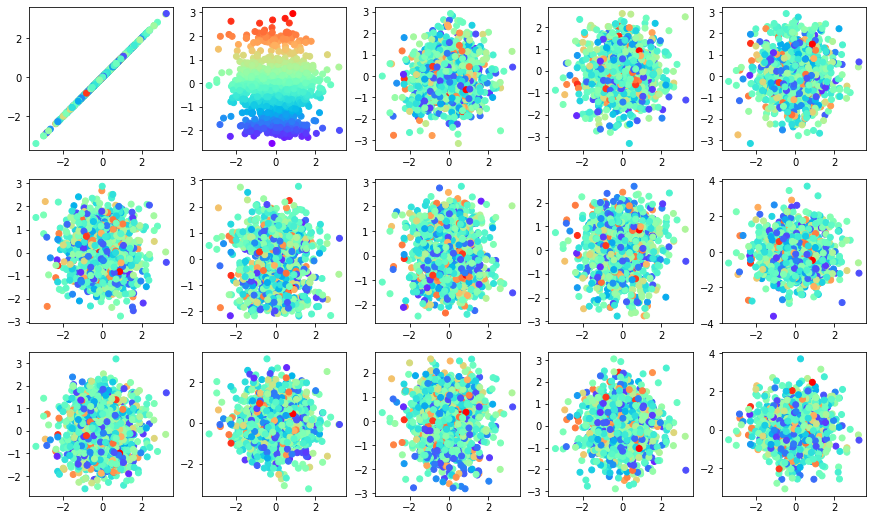

In [21]:
import matplotlib.cm as cm
%matplotlib inline
plt.figure(figsize=(15,9))
x_index = 0
color_index = 1
colors = cm.rainbow((encoded_values[:,color_index]-np.min(encoded_values[:,color_index]))/(np.max(encoded_values[:,color_index])-np.min(encoded_values[:,color_index])))
for i in range(15):
    plt.subplot(3,5,i+1)
    plt.scatter(encoded_values[:,x_index],encoded_values[:,i],color=colors)
    plt.xlabel("")

In [26]:
len(frames)

3200

In [8]:
result = frame
RGB_img = cv2.cvtColor(np.uint8(255*result), cv2.COLOR_BGR2RGB)
cv2.imwrite('../../../../Mech Punk/Documents/sample_image.png',RGB_img)

True

In [22]:
# encoded_values = encoder_model.predict(np.array(frames[0:1000]))
mean_encoded_frames = np.mean(encoded_values,axis=0)
min_encoded_frames = np.min(encoded_values,axis=0)
max_encoded_frames = np.max(encoded_values,axis=0)
std_encoded_frames = np.std(encoded_values,axis=0)

In [23]:
mean_encoded_frames

array([-0.00796648, -0.18768631, -0.02132461, -0.04974115,  0.01121819,
        0.01178946, -0.00583699,  0.01024372,  0.13182919, -0.03329627,
       -0.00346602, -0.00330093,  0.11175073, -0.03358011,  0.07118328,
        0.00054325], dtype=float32)

In [24]:
std_encoded_frames

array([1.0016094 , 1.005265  , 0.97651374, 0.97850156, 1.0089786 ,
       1.0564911 , 1.0613098 , 1.0935097 , 1.0541029 , 1.0204058 ,
       1.0350733 , 0.95954645, 1.0251125 , 0.9859544 , 0.99934644,
       1.0420083 ], dtype=float32)

In [25]:
%matplotlib qt 
from tkinter import *
from IPython.display import clear_output
import time

master = Tk()

plt.figure(figsize=(14,5))
sp1 = plt.subplot(1,2,1)
sp2 = plt.subplot(1,2,2)

last_time_rendered=time.time()
initial_frame = 0
current_values = encoded_values[initial_frame].copy()
def change_values():
    global last_time_rendered
    current_time = time.time()
    if current_time - last_time_rendered < 0.25:
        return
    
    for slider_index, slider in enumerate(sliders):
        current_values[slider_index]=slider.get()
    clear_output()
    last_time_rendered = current_time
    prediction = decoder_model.predict(current_values.reshape(1,-1))[0]
    base_line = decoder_model.predict(encoded_values[initial_frame].reshape(1,-1))[0]
    
    sp1.clear()
    sp1.imshow(prediction)
    sp2.clear()
    sp2.imshow(np.abs(prediction-base_line))
    plt.draw()
    
def reset_values():
    global current_values
    current_values = encoded_values[initial_frame].copy()
    for slider_index, slider in enumerate(sliders):
        initial_value = current_values[slider_index]
        slider.set(initial_value)
    change_values()
        
    
sliders=[]
number_of_sliders = len(mean_encoded_frames)
labels = {
    1:"walls",
    4:"hand",
    5:"dash",
    6:"shoot",
    7:"dash",
    8:"up/down",
    10:"Up/down",
    12: "Wall closing up"
}
for slider_index in range(number_of_sliders):
    mean_value = mean_encoded_frames[slider_index]
    std_value = std_encoded_frames[slider_index]
    min_value = min_encoded_frames[slider_index]
    max_value = max_encoded_frames[slider_index]
    initial_value = current_values[slider_index]
    try:
        label_name = labels[slider_index]
    except:
        label_name = "{}".format(slider_index)
    row_index, column_index = divmod(slider_index,8)
    label = Label(master,text=label_name)
    label.grid(row = row_index, column = 2*column_index, pady=1, padx = 2)
    slider = Scale(master, 
                   from_=min_value, 
                   to=max_value, 
                   resolution=0.00001, 
                   orient=HORIZONTAL, 
                   command=lambda value: change_values())
    slider.set(initial_value)
#     slider.pack(side=BOTTOM)
    slider.grid(row = row_index, column = 2*column_index+1, pady=1, padx = 2)
    sliders.append(slider)
    
button = Button (master, text="   RESET   ", command=reset_values)
button.grid(row=row_index+1)

mainloop()

# 1700

KeyboardInterrupt: 

In [36]:
slider.

<tkinter.Scale object .!scale32>

In [193]:
fourcc =  cv2.VideoWriter_fourcc(*'mp4v')
videowriter = cv2.VideoWriter(output_path,fourcc, fps, (640,480))
for result in results:
    RGB_img = cv2.cvtColor(np.uint8(255*result), cv2.COLOR_BGR2RGB)
    videowriter.write(RGB_img)
videowriter.release()

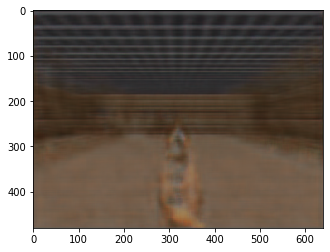

In [192]:
plt.imshow(np.uint8(255*result))

In [183]:

out = cv2.VideoWriter(output_path,cv2.VideoWriter_fourcc(*'DIVX'), fps, (480,640))
for i in range(len(results)):
    # writing to a image array
    out.write(np.uint8(results[i]))
out.release()

In [70]:
game.close()

In [142]:
autoencoder_model.summary()

Model: "model_21"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_27 (InputLayer)        [(None, 480, 640, 3)]     0         
_________________________________________________________________
conv2d_62 (Conv2D)           (None, 480, 640, 8)       224       
_________________________________________________________________
max_pooling2d_53 (MaxPooling (None, 240, 320, 8)       0         
_________________________________________________________________
conv2d_63 (Conv2D)           (None, 240, 320, 16)      1168      
_________________________________________________________________
max_pooling2d_54 (MaxPooling (None, 120, 160, 16)      0         
_________________________________________________________________
conv2d_64 (Conv2D)           (None, 120, 160, 32)      4640      
_________________________________________________________________
max_pooling2d_55 (MaxPooling (None, 60, 80, 32)        0  

In [132]:
frame = (screen_buf/255)

In [144]:
encoded_frame = encoder_model.predict(np.expand_dims(frame, 0))
encoded_frame

array([[-0.0639854 , -0.12212464,  0.12227813, -0.1574321 ,  0.15349567,
        -0.08113714, -0.02606815,  0.15255773,  0.07415448, -0.09375374,
        -0.10602891,  0.05207051,  0.12839992, -0.14103197,  0.29119465,
        -0.10072614,  0.12248326,  0.06323166,  0.08846203, -0.04380043,
         0.06410899,  0.05987906,  0.0982798 , -0.09744385, -0.04132511,
        -0.09595089,  0.31295055, -0.02734107,  0.05040722,  0.01034025,
         0.03155817, -0.28869236]], dtype=float32)

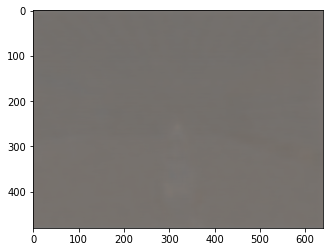

In [165]:
plt.imshow(decoder_model.predict(encoded_frame)[0])

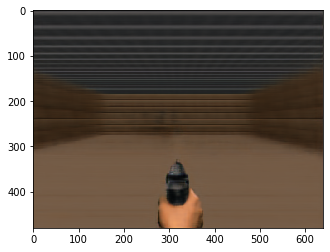

In [251]:
plt.imshow(autoencoder_model.predict(np.expand_dims(screen_buf/255, 0))[0])

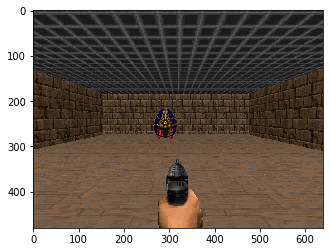

In [250]:
plt.imshow(screen_buf/255)

In [246]:
def get_game_state(state):
    game_object_state = []
    for game_object in state.objects:
        game_object_state = [
            game_object.angle,
    #         game_object.name,
            game_object.pitch,
            game_object.position_x,
            game_object.position_y,
            game_object.position_z,
            game_object.roll,
            game_object.velocity_x,
            game_object.velocity_y,
            game_object.velocity_z,]
        game_object_state+=game_object_state
    return game_object_state

In [247]:
get_game_state(state)

[180.00000004190952,
 0.0,
 0.0,
 60.504974365234375,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 180.00000004190952,
 0.0,
 0.0,
 60.504974365234375,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0]

In [236]:
state.objects[0].roll

0.0

In [237]:
game_object_states

[[0.0, 0.0, -384.0, 26.379196166992188, 0.0, 0.0, 0.0, -1.72308349609375, 0.0],
 [180.00000004190952, 0.0, 0.0, 60.504974365234375, 0.0, 0.0, 0.0, 0.0, 0.0]]

Episode #1


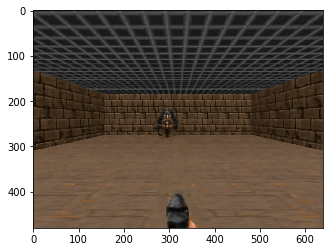

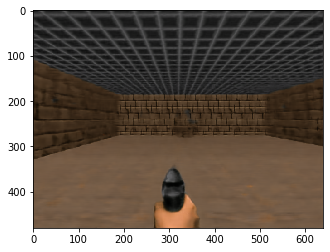

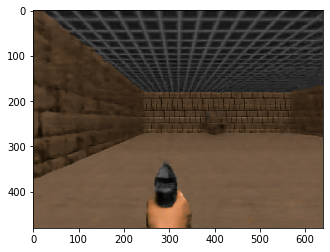

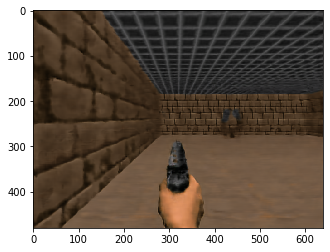

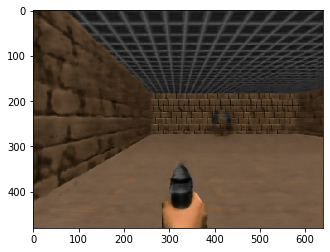

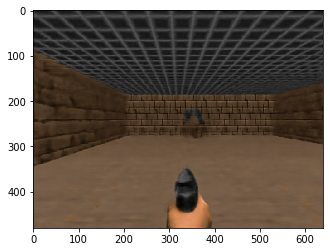

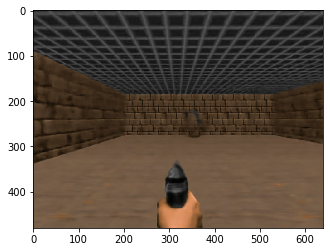

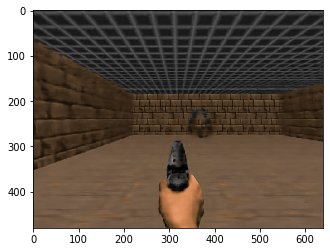

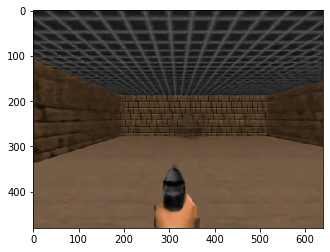

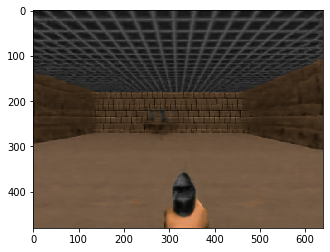

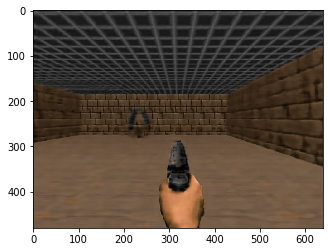

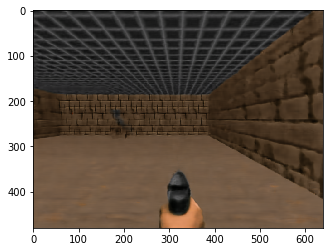

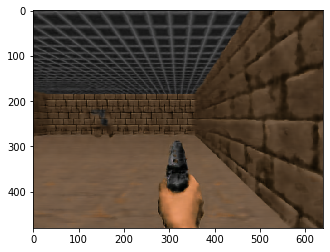

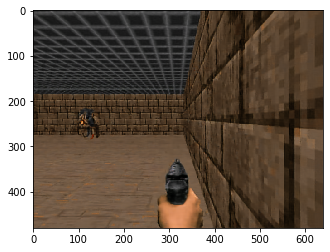

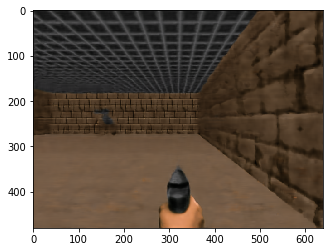

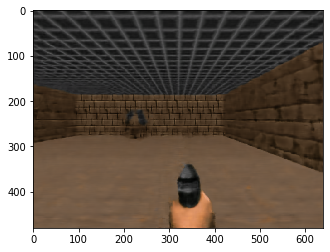

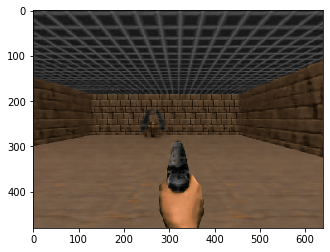

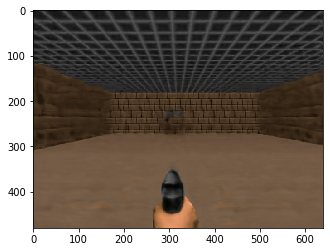

Episode #2


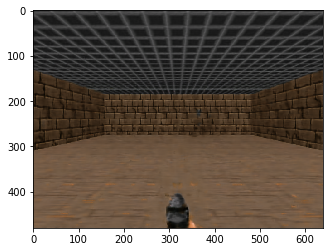

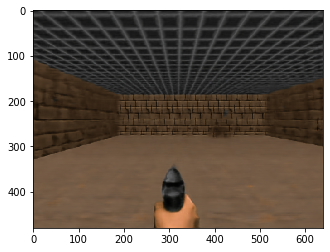

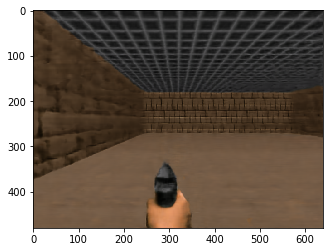

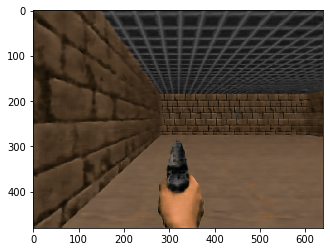

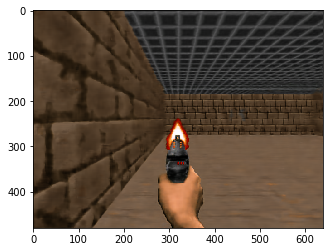

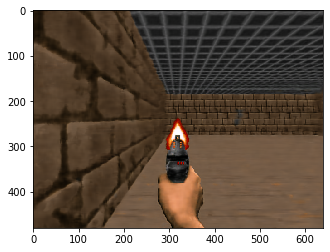

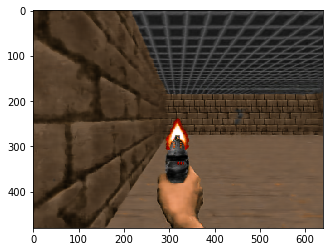

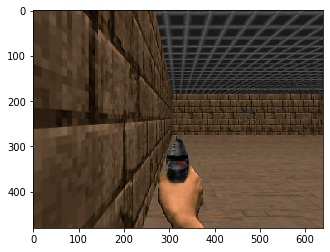

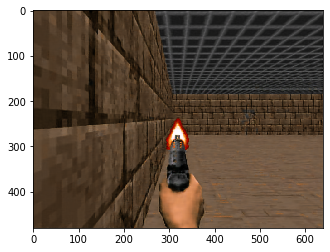

KeyboardInterrupt: 

In [35]:
# Play
vizdoom_path = "../../../../Mech Punk/Anaconda3/envs/vizdoom/lib/vizdoom/scenarios/"

if __name__ == "__main__":
    # Create DoomGame instance. It will run the game and communicate with you.
    game = vzd.DoomGame()

    # Now it's time for configuration!
    # load_config could be used to load configuration instead of doing it here with code.
    # If load_config is used in-code configuration will also work - most recent changes will add to previous ones.
    # game.load_config("../../scenarios/basic.cfg")

    # Sets path to additional resources wad file which is basically your scenario wad.
    # If not specified default maps will be used and it's pretty much useless... unless you want to play good old Doom.
    game.set_doom_scenario_path(vizdoom_path + "basic.wad")
    # Sets map to start (scenario .wad files can contain many maps).
    game.set_doom_map("map01")

    # Sets resolution. Default is 320X240
    game.set_screen_resolution(vzd.ScreenResolution.RES_640X480)

    # Sets the screen buffer format. Not used here but now you can change it. Default is CRCGCB.
    game.set_screen_format(vzd.ScreenFormat.RGB24)

    # Enables depth buffer.
    game.set_depth_buffer_enabled(True)

    # Enables labeling of in game objects labeling.
    game.set_labels_buffer_enabled(True)

    # Enables buffer with top down map of the current episode/level.
    game.set_automap_buffer_enabled(True)

    # Enables information about all objects present in the current episode/level.
    game.set_objects_info_enabled(True)

    # Enables information about all sectors (map layout).
    game.set_sectors_info_enabled(True)

    # Sets other rendering options (all of these options except crosshair are enabled (set to True) by default)
    game.set_render_hud(False)
    game.set_render_minimal_hud(False)  # If hud is enabled
    game.set_render_crosshair(False)
    game.set_render_weapon(True)
    game.set_render_decals(False)  # Bullet holes and blood on the walls
    game.set_render_particles(False)
    game.set_render_effects_sprites(False)  # Smoke and blood
    game.set_render_messages(False)  # In-game messages
    game.set_render_corpses(False)
    game.set_render_screen_flashes(True)  # Effect upon taking damage or picking up items

    # Adds buttons that will be allowed.
    game.add_available_button(vzd.Button.MOVE_LEFT)
    game.add_available_button(vzd.Button.MOVE_RIGHT)
    game.add_available_button(vzd.Button.ATTACK)

    # Adds game variables that will be included in state.
    game.add_available_game_variable(vzd.GameVariable.AMMO2)

    # Causes episodes to finish after 200 tics (actions)
    game.set_episode_timeout(300)

    # Makes episodes start after 10 tics (~after raising the weapon)
    game.set_episode_start_time(10)

    # Makes the window appear (turned on by default)
    game.set_window_visible(False)

    # Turns on the sound. (turned off by default)
    game.set_sound_enabled(False)

    # Sets the livin reward (for each move) to -1
    game.set_living_reward(-1)

    # Sets ViZDoom mode (PLAYER, ASYNC_PLAYER, SPECTATOR, ASYNC_SPECTATOR, PLAYER mode is default)
    game.set_mode(vzd.Mode.PLAYER)

    # Enables engine output to console.
    #game.set_console_enabled(True)

    # Initialize the game. Further configuration won't take any effect from now on.
    game.init()

    # Define some actions. Each list entry corresponds to declared buttons:
    # MOVE_LEFT, MOVE_RIGHT, ATTACK
    # game.get_available_buttons_size() can be used to check the number of available buttons.
    # 5 more combinations are naturally possible but only 3 are included for transparency when watching.
    actions = [[True, False, False], [False, True, False], [False, False, True]]

    # Run this many episodes
    episodes = 100000000

    # Sets time that will pause the engine after each action (in seconds)
    # Without this everything would go too fast for you to keep track of what's happening.
    sleep_time = 1.0 / vzd.DEFAULT_TICRATE  # = 0.028
    

    for i in range(episodes):
        print("Episode #" + str(i + 1))

        # Starts a new episode. It is not needed right after init() but it doesn't cost much. At least the loop is nicer.
        game.new_episode()

        action_counter = 0
        counter = 0
        
        
        while not game.is_episode_finished():
            
            action_counter-=1

            # Gets the state
            state = game.get_state()

            # Which consists of:
            n = state.number
            vars = state.game_variables
            screen_buf = state.screen_buffer
            depth_buf = state.depth_buffer
            labels_buf = state.labels_buffer
            automap_buf = state.automap_buffer
            labels = state.labels
            objects = state.objects
            sectors = state.sectors
            
            time.sleep(0.1)
            
            frame = screen_buf/255
            plt.imshow(autoencoder_model.predict(np.expand_dims(frame,0))[0])
            plt.show()
#             if action_counter < 0:
#                 action = choice(actions)
#                 action_counter = np.random.randint(0,20)
            action = choice(actions)
            r = game.make_action(action,12)

In [ ]:
game.make_action(action)

In [14]:
encodings = encoder_model.predict(np.array(frames[0:100]))

In [22]:
encoding_drawing = encodings.mean(axis=0) + encodings.std(axis=0) * np.random.randn(32)

In [25]:
frame_drawing = decoder_model.predict(encoding_drawing.reshape(1,-1))[0]

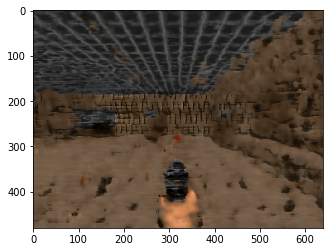

In [27]:
plt.imshow(frame_drawing)